In [255]:
# For the NOAA data buoys I would choose this one as an important and representative example:
# Station MOK1  (Station Page) in Kaneohe Bay (MOK for Moku o Loe, Coconut Island, where HIMB is).
# http://www.ndbc.noaa.gov/station_page.php?station=mokh1
#      [displays station, past 24 hrs of data, links to older data at the bottom of the page]
#      "real-time data" shows the past 45 days
#      "historic data" shows past years by year, current year downloadable by month

# Historic data is probably the best to use for a first example since it's stable (quality checked, not provisional)
# and comes in reasonably big and useful chunks.
  
# The variable we care about for corals is collected as part of "standard meteorological data" suite, 
# and is Sea Surface Temperature, column heading WTMP in NOAA data files.
# "WTMP Sea surface temperature (Celsius). For buoys the depth is referenced to the hull's waterline. 
# For fixed platforms it varies with tide, but is referenced to, or near Mean Lower Low Water (MLLW)."
# - from http://www.ndbc.noaa.gov/measdes.shtml . 

# Example 1: I need to plot sea surface temperature (SST) data for 2014 and 2015 (bleaching years)., 
#     The historic data is stable, available for a year at a time, and comes in a slightly different text 
#     format than more recent data. I would find that linked from the Station Page as "historic data" link at the bottom:
# http://www.ndbc.noaa.gov/station_history.php?station=mokh1

#     From the historic data page http://www.ndbc.noaa.gov/station_history.php?station=mokh1
# I choose historic -- standard meteorological data -- click on year links (2014) and choose .txt or .gz
# (mokh1h2014.txt is at http://www.ndbc.noaa.gov/view_text_file.php?filename=mokh1h2014.txt.gz&dir=data/historical/stdmet/)
# (mokh1h2014.txt.gz is at http://www.ndbc.noaa.gov/data/historical/stdmet/mokh1h2014.txt.gz)

# One exercise I've done in R (presumably also doable in Python) is to download and plot 
# these datasets for a year at a time, or multiple years overlaid on an annual axis to see 
# variation, x axis running Jan-Dec (watch out for leap years). 
# There's some work required in (1) aggregating the parsed date and time into reasonable 
# columns to use for plotting (2) checking for and filling in missing date or time gaps with NA or blanks, 
# and converting the ubiquitous 999 to NA or blanks, (3) subsampling the data at regular intervals 
# if you just don't want to fool with that size dataset (first reading of the day) or 
# aggregating (daily average) - some of these interval choices or time averages may be impacted 
# by high-frequency down times (assumed to be equipment maintenance or self-checks), and especially 
# (4) potentially harvesting or exporting the resulting csv to use in other programs (a very common need), 
# in the process deleting columns of no interest. (5) Also - if I recall, NOAA .txt datasets have 2 (maybe 3) 
# top lines taken up in specifying column header information, and for any reasonable kind of downstream use, 
# one will want to export a clean csv with column headings of: one line only, no spaces or special characters, 
# only numbers letters dashes and underscores, maybe the ability to rename with something more explicit like 
# WaterTemp_degC instead of  WTMP (which even today took some lookup time to rediscover/re-remember 
# that WTMP actually meant SST). 

# Additional feature. It can be useful to add to the graph (1) a straight horizontal line of one's 
# choosing (e.g., mean annual temperature, or user-specified physiological tolerance temperature thresholds for 
#           (a) coral stress or (b) coral death). 

# Additional feature. With access to many years' worth of data, it would also be useful to plot selected years 
# along with an average temperature (same time interval as the year being plotted - such as daily) for 
# the past decade, or all years, to compare magnitude and timing of temperature spikes during bleaching years 
# to the usual temperature for that time of year (and the user knowing from other data, such as field observations,
# when the first signs of bleaching or paling were seen for that year).

# Additional feature. Note that the "bleaching season" tends to occur in the fall, so to observe 
# full warming and recovery cycles, people might want to offset the starting month (Apr-Mar rather than Jan-Dec). 
# Nice but maybe later, as with the other "additional features").


In [256]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import urllib.request, json
from datetime import datetime, date, time

#Set URL of notebook to http://localhost:8888/notebooks/github_repos/Mok1-Sea-Data/Ouida.ipynb?docID=65bbd72fc0b44da390f3a2007600d6be&var=65bbd72fc0b44da390f3a2007600d6be

In [257]:
%%javascript
function getQueryStringValue (key)
{  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("docID='".concat(getQueryStringValue("docID")).concat("'"));
IPython.notebook.kernel.execute("var='".concat(getQueryStringValue("var")).concat("'"));



<IPython.core.display.Javascript object>

In [258]:

#construct url from variable
cinergi_url = "http://cinergi.sdsc.edu/geoportal/rest/metadata/item/" + docID

test_data = ''
with urllib.request.urlopen(cinergi_url) as url:
    data = json.loads(url.read().decode())
    data = data["_source"]["links_s"]
    test_data = pd.read_csv(data, delim_whitespace=True, header=[0,1], na_values=['99.0','999.0','99.00','999','9999.0' ])

# Preview Data from Cinergi URL
print(var)

65bbd72fc0b44da390f3a2007600d6be


In [259]:
# file we are working with
# file1_url = "http://www.ndbc.noaa.gov/view_text_file.php?filename=mokh1h2014.txt.gz&dir=data/historical/stdmet/"

data = []
#Current ways of importing the files
file1_local = 'mokh1h2014.txt'
file2_local = 'mokh1h2015.txt'

# Reading in the files
df = pd.read_csv(file1_local, delim_whitespace=True, header=[0,1], na_values=['99.0','999.0','99.00','999','9999.0' ])
df2= pd.read_csv(file2_local, delim_whitespace=True, header = [0,1], na_values =['99.0','999.0','99.00','999','9999.0' ])
data.append(df)
data.append(df2)
for i in range(len(data)):
    data[i].fillna('')

In [260]:
def simplify_column_names(df):
    new_header = []
    for i in (list(df.columns.values)):
        if len(i) == 1:
            new_header.append(i[0])
        elif len(i) == 2:
            new_header.append('%s (%s)'%(i[0],i[1]))
    df.columns = new_header
    return df

for i in range(len(data)):
    data[i] = simplify_column_names(data[i])


In [261]:
#Creates a datetime object based on the dates and times and appends to the existing dataframe

#function to streamline the operation
def createDateTime(df):
    df_temp = df[['#YY (#yr)', 'MM (mo)','DD (dy)','hh (hr)','mm (mn)']].copy()
    df_temp.columns = ['year', 'month', 'day', 'hour', 'minute']
    df_temp = pd.to_datetime(df_temp)

    df_temp = pd.DataFrame({'date_time': df_temp})
    df = pd.concat([df,df_temp], axis = 1)
    return df

for i in range(len(data)):
    data[i] = createDateTime(data[i])

# Create Key Values.
graphKeyVals = []

for i in range(len(data)):
    graphKeyVals.append( data[i]['date_time'][0].year)
    
    data[i]['date_time'] = data[i]['date_time'].apply(lambda x: x.replace(year= 2014))


data[0],data[1]
#More sophisticated code must be implemented here to handle multiple data sets.
#Takes the 2015 dataset and moves the data down by 1 in order to maintain the same year.
graphKeyVals

[2014, 2015]

Populating the interactive namespace from numpy and matplotlib


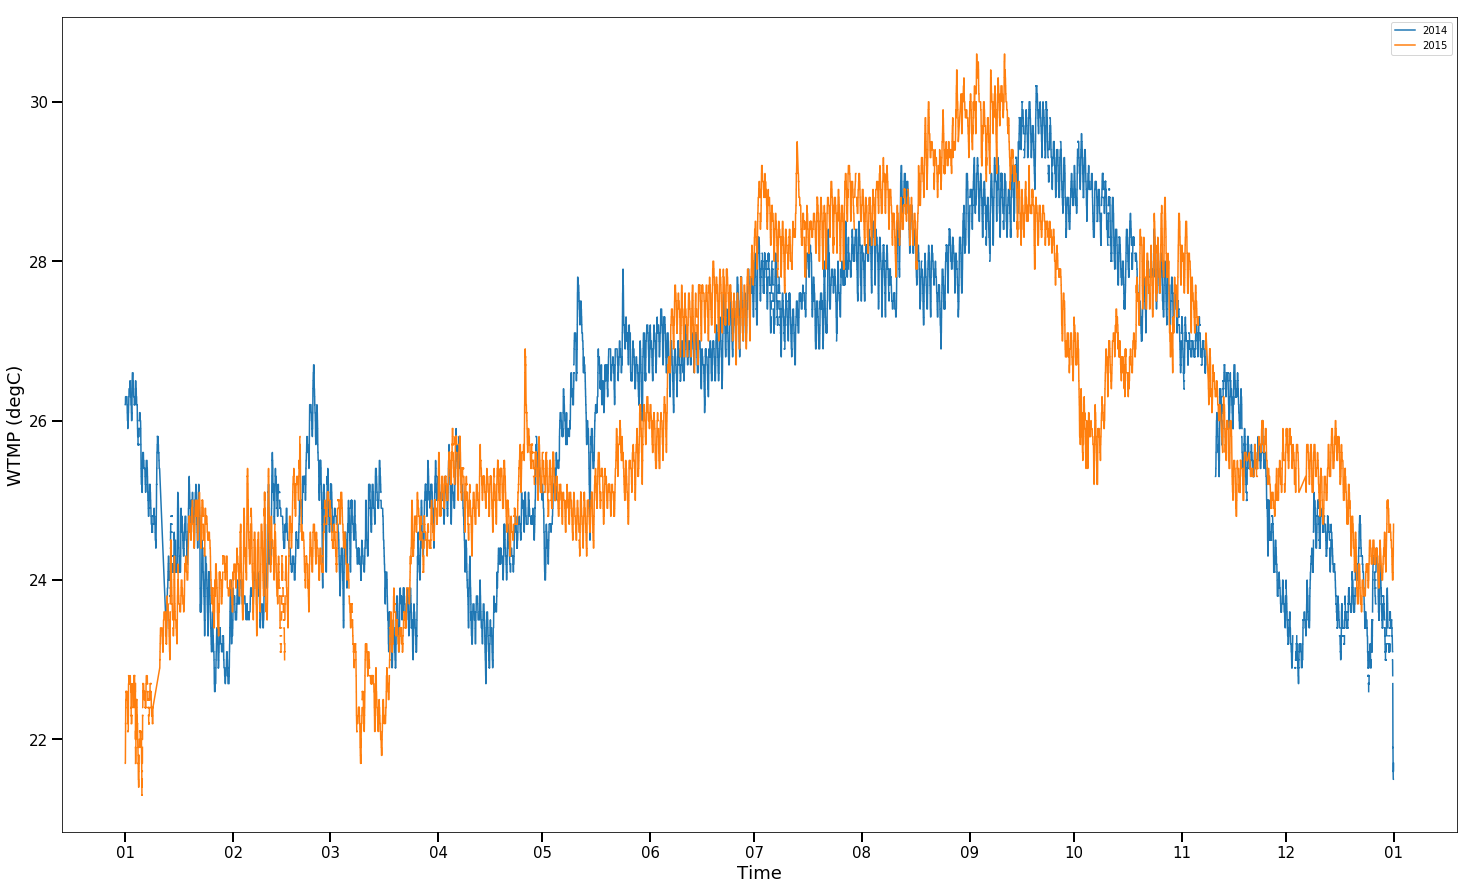

In [265]:
# Example plot of the image based on values of WTMP (Can be changed to other variables)

#Sets the size of the figure in the notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (25, 15)


for i in range(len(data)):
    plt.plot(data[i]['date_time'],data[i]['WTMP (degC)'], label = str(graphKeyVals[i]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    #fontsize of the tick labels
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize = 15)

    #Size of ticks
    plt.tick_params(direction='out', length=10, width=2,)

    #X and Y labels
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('WTMP (degC)',fontsize=18)


plt.legend(loc = "best")
plt.show()


In [263]:
df.head()

,#YY (#yr),MM (mo),DD (dy),hh (hr),mm (mn),WDIR (degT),WSPD (m/s),GST (m/s),WVHT (m),DPD (sec),APD (sec),MWD (degT),PRES (hPa),ATMP (degC),WTMP (degC),DEWP (degC),VIS (mi),TIDE (ft)
0,2014,1,1,0,0,101.0,4.3,5.3,NaN,NaN,NaN,NaN,1014.4,26.1,26.2,NaN,NaN,NaN
1,2014,1,1,0,6,111.0,3.7,5.8,NaN,NaN,NaN,NaN,1014.3,26.0,26.2,NaN,NaN,NaN
2,2014,1,1,0,12,103.0,4.6,6.3,NaN,NaN,NaN,NaN,1014.1,26.0,26.2,NaN,NaN,NaN
3,2014,1,1,0,18,104.0,4.3,5.9,NaN,NaN,NaN,NaN,1014.0,25.9,26.2,NaN,NaN,NaN
4,2014,1,1,0,24,106.0,4.1,5.5,NaN,NaN,NaN,NaN,1014.0,25.9,26.2,NaN,NaN,NaN


In [264]:

def changeColumnNames(df):
    df.columns = ['year','month','day','hour','minute','WDIR','WSPD','GST','WVHT','DPD','APD','MWD','PRES','ATMP','WTMP','DEWP','VIS','TIDE',
                  'date_time']
    return df


df_test = changeColumnNames(df)
df_test2 = changeColumnNames(df2)

result = pd.concat([df_test,df_test2])
result.tail()

ValueError: Length mismatch: Expected axis has 18 elements, new values have 19 elements

In [ ]:
piv = pd.pivot_table(result, index=['month'],columns=['year'], values=['WTMP'])
piv.plot()